In [0]:
# этот ноутбук в google colab 
# https://colab.research.google.com/drive/1_oV3Pz-nZaYzoo4BZ-HOA3J4eKqk74x5

# in google colab uncomment this

import os

os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')

# launch XVFB if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=: 1


### Let's make a TRPO!

In this notebook we will write the code of the one Trust Region Policy Optimization.
As usually, it contains a few different parts which we are going to reproduce.



In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
import gym

env = gym.make("Acrobot-v1")
env.reset()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
print("Observation Space", env.observation_space)
print("Action Space", env.action_space)

Observation Space Box(6,)
Action Space Discrete(3)
Observation Space Box(6,)
Action Space Discrete(3)


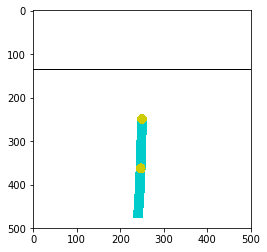

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(env.render('rgb_array'))

### Step 1: Defining a network

With all it's complexity, at it's core TRPO is yet another policy gradient method. 

This essentially means we're actually training a stochastic policy $ \pi_\theta(a|s) $. 

And yes, it's gonna be a neural network. So let's start by defining one.

In [0]:
class TRPOAgent(nn.Module):
    def __init__(self, state_shape, n_actions, hidden_size=128):
        '''
        Here you should define your model
        You should have LOG-PROBABILITIES as output because you will need it to compute loss
        We recommend that you start simple: 
        use 1-2 hidden layers with 100-500 units and relu for the first try
        '''
        super(TRPOAgent,self).__init__()

        
        self.model = nn.Sequential(nn.Linear(state_shape[0], hidden_size),
                     nn.ReLU(),
                     nn.Linear(hidden_size, hidden_size),
                     nn.ReLU(),
                      nn.Linear(hidden_size, n_actions),
                     nn.LogSoftmax())

    def forward(self, states):
        """
        takes agent's observation (Variable), returns log-probabilities (Variable)
        :param state_t: a batch of states, shape = [batch_size, state_shape]
        """

        # Use your network to compute log_probs for given state
        log_probs = self.model(states)
        return log_probs

    def get_log_probs(self, states):
        '''
        Log-probs for training
        '''

        return self.forward(states)

    def get_probs(self, states):
        '''
        Probs for interaction
        '''

        return torch.exp(self.forward(states))

    def act(self, obs, sample=True):
        '''
        Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
        :param: obs - single observation vector
        :param sample: if True, samples from \pi, otherwise takes most likely action
        :returns: action (single integer) and probabilities for all actions
        '''

        probs = self.get_probs(torch.FloatTensor([obs])).data.numpy()

        if sample:
            action = int(np.random.choice(n_actions, p=probs[0]))
        else:
            action = int(np.argmax(probs))

        return action, probs[0]


agent = TRPOAgent(observation_shape, n_actions)

In [0]:
# Check if log-probabilities satisfies all the requirements
log_probs = agent.get_log_probs(torch.FloatTensor([env.reset()]))
assert log_probs.requires_grad, "qvalues must be a torch tensor with grad"
assert len(
    log_probs.shape) == 2 and log_probs.shape[0] == 1 and log_probs.shape[1] == n_actions
sums = torch.sum(torch.exp(log_probs), dim=1)
assert (0.999 < sums).all() and (1.001 > sums).all()

# Demo use
print("sampled:", [agent.act(env.reset()) for _ in range(5)])
print("greedy:", [agent.act(env.reset(), sample=False) for _ in range(5)])

sampled: [(1, array([0.27565548, 0.3772354 , 0.34710908], dtype=float32)), (0, array([0.2747131 , 0.37713453, 0.3481524 ], dtype=float32)), (2, array([0.2750938 , 0.37725896, 0.34764716], dtype=float32)), (0, array([0.27430654, 0.3781341 , 0.34755936], dtype=float32)), (2, array([0.27562425, 0.37723002, 0.34714574], dtype=float32))]
greedy: [(1, array([0.27522305, 0.3770664 , 0.3477105 ], dtype=float32)), (1, array([0.27549174, 0.3778428 , 0.34666538], dtype=float32)), (1, array([0.27634597, 0.3777832 , 0.34587088], dtype=float32)), (1, array([0.27602547, 0.3780179 , 0.34595662], dtype=float32)), (1, array([0.27447042, 0.37826294, 0.34726664], dtype=float32))]


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


#### Flat parameters operations

We are going to use it

In [0]:
def get_flat_params_from(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))

    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].view(param.size()))
        prev_ind += flat_size

Compute cumulative reward just like you did in vanilla REINFORCE

In [0]:

def get_cumulative_returns(r, gamma=1):
    """
    Computes cumulative discounted rewards given immediate rewards
    G_i = r_i + gamma*r_{i+1} + gamma^2*r_{i+2} + ...
    Also known as R(s,a).
    """
    r = np.array(r)
    assert r.ndim >= 1
    return np.array([np.dot( gamma**np.arange(0,len(r)-i+0), r[i:] ) for i in range(len(r))])

In [0]:
# simple demo on rewards [0,0,1,0,0,1]
get_cumulative_returns([0, 0, 1, 0, 0, 1], gamma=0.9)

array([1.40049, 1.5561 , 1.729  , 0.81   , 0.9    , 1.     ])

**Rollout**

In [0]:
def rollout(env, agent, max_pathlength=2500, n_timesteps=50000):
    """
    Generate rollouts for training.
    :param: env - environment in which we will make actions to generate rollouts.
    :param: act - the function that can return policy and action given observation.
    :param: max_pathlength - maximum size of one path that we generate.
    :param: n_timesteps - total sum of sizes of all pathes we generate.
    """
    paths = []

    total_timesteps = 0
    while total_timesteps < n_timesteps:
        observations, actions, rewards, action_probs = [], [], [], []
        observation = env.reset()
        for _ in range(max_pathlength):
            action, policy = agent.act(observation)
            observations.append(observation)
            actions.append(action)
            action_probs.append(policy)
            observation, reward, done, _ = env.step(action)
            rewards.append(reward)
            total_timesteps += 1
            if done or total_timesteps == n_timesteps:
                path = {"observations": np.array(observations),
                        "policy": np.array(action_probs),
                        "actions": np.array(actions),
                        "rewards": np.array(rewards),
                        "cumulative_returns": get_cumulative_returns(rewards),
                        }
                paths.append(path)
                break
    return paths

In [0]:
paths = rollout(env, agent, max_pathlength=5, n_timesteps=100)
print(paths[-1])
assert (paths[0]['policy'].shape == (5, n_actions))
assert (paths[0]['cumulative_returns'].shape == (5,))
assert (paths[0]['rewards'].shape == (5,))
assert (paths[0]['observations'].shape == (5,)+observation_shape)
assert (paths[0]['actions'].shape == (5,))
print('It\'s ok')

{'observations': array([[ 0.99786821, -0.06526131,  0.9998829 , -0.01530345,  0.04826368,
        -0.03406411],
       [ 0.998096  , -0.06167963,  0.99996564,  0.00829017, -0.01224285,
         0.26621897],
       [ 0.99759776, -0.06927277,  0.99618967,  0.0872132 , -0.05961429,
         0.50889464],
       [ 0.99838579, -0.0567963 ,  0.99082509,  0.13515042,  0.18304017,
        -0.0319071 ],
       [ 0.99992319, -0.0123939 ,  0.99380295,  0.11115618,  0.25143911,
        -0.19876378]]), 'policy': array([[0.27487838, 0.37693143, 0.34819034],
       [0.2753873 , 0.37685126, 0.34776148],
       [0.27608177, 0.37691057, 0.3470076 ],
       [0.273094  , 0.37989166, 0.34701437],
       [0.2719149 , 0.38020763, 0.34787747]], dtype=float32), 'actions': array([2, 2, 0, 1, 1]), 'rewards': array([-1., -1., -1., -1., -1.]), 'cumulative_returns': array([-5., -4., -3., -2., -1.])}
It's ok


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Step 3: Auxiliary functions

Now let's define the loss functions and something else for actual TRPO training.

The surrogate reward should be
$$J_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}A_{\theta_{old}(s_i, a_i)}$$

For simplicity, let's use cumulative returns instead of advantage for now:
$$J'_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}G_{\theta_{old}(s_i, a_i)}$$

Or alternatively, minimize the surrogate loss:
$$ L_{surr} = - J'_{surr} $$  


In [0]:
def get_loss(agent, observations, actions, cumulative_returns, old_probs):
    """
    Computes TRPO objective
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cumulative_returns - batch of cumulative returns
    :param: old_probs - batch of probabilities computed by old network
    :returns: scalar value of the objective function
    """
    batch_size = observations.shape[0]
#     log_probs_all = agent.get_log_probs(observations)
#     probs_all = torch.exp(log_probs_all) # заменить на get_probs
    probs_all = agent.get_probs(observations)

    probs_for_actions = probs_all[torch.arange(
        0, batch_size, out=torch.LongTensor()), actions]
    old_probs_for_actions = old_probs[torch.arange(
        0, batch_size, out=torch.LongTensor()), actions]

    # Compute surrogate loss, aka importance-sampled policy gradient
#     Loss = 
    assert Loss.shape == torch.Size([])
    return Loss

We can ascend these gradients as long as our $\pi_\theta(a|s)$ satisfies the constraint
$$E_{s,\pi_{\Theta_{t}}}\Big[KL(\pi(\Theta_{t}, s) \:||\:\pi(\Theta_{t+1}, s))\Big]< \alpha$$


where

$$KL(p||q) = E _p log({p \over q})$$

In [0]:
def get_kl(agent, observations, actions, cumulative_returns, old_probs):
    """
    Computes KL-divergence between network policy and old policy
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cumulative_returns - batch of cumulative returns (we don't need it actually)
    :param: old_probs - batch of probabilities computed by old network
    :returns: scalar value of the KL-divergence
    """
    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)

    # Compute Kullback-Leibler divergence (see formula above)
    # Note: you need to sum KL and entropy over all actions, not just the ones agent took
    old_log_probs = torch.log(old_probs+1e-10)
    
#     print((old_log_probs-log_probs_all),probs_all)

#     kl = 
#     print(torch.sum((old_log_probs-log_probs_all)*probs_all))
    assert kl.shape == torch.Size([])
    assert (kl > -0.0001).all() and (kl < 10000).all()
    return kl

In [0]:
def get_entropy(agent, observations):
    """
    Computes entropy of the network policy 
    :param: observations - batch of observations
    :returns: scalar value of the entropy
    """

    observations = torch.FloatTensor(observations)

    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)

    entropy = torch.sum(-probs_all * log_probs_all) / batch_size

    assert entropy.shape == torch.Size([])
    return entropy

**Linear search**

TRPO in its core involves ascending surrogate policy gradient constrained by KL divergence. 

In order to enforce this constraint, we're gonna use linesearch. You can find out more about it [here](https://en.wikipedia.org/wiki/Linear_search)

In [0]:
def linesearch(f, x, fullstep, max_kl):
    """
    Linesearch finds the best parameters of neural networks in the direction of fullstep contrainted by KL divergence.
    :param: f - function that returns loss, kl and arbitrary third component.
    :param: x - old parameters of neural network.
    :param: fullstep - direction in which we make search.
    :param: max_kl - constraint of KL divergence.
    :returns:
    """
    max_backtracks = 10
    loss, _, = f(x)
    for stepfrac in .5**np.arange(max_backtracks):
        xnew = x + stepfrac * fullstep
        new_loss, kl = f(xnew)
        actual_improve = new_loss - loss
        if kl.data.numpy() <= max_kl and actual_improve.data.numpy() < 0:
            x = xnew
            loss = new_loss
    return x

**Conjugate gradients**

Since TRPO includes contrainted optimization, we will need to solve Ax=b using conjugate gradients.

In general, CG is an algorithm that solves Ax=b where A is positive-defined. A is Hessian matrix so A is positive-defined. You can find out more about them [here](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

In [0]:
from numpy.linalg import inv


def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    """
    This method solves system of equation Ax=b using iterative method called conjugate gradients
    :f_Ax: function that returns Ax
    :b: targets for Ax
    :cg_iters: how many iterations this method should do
    :residual_tol: epsilon for stability
    """
    p = b.clone()
    r = b.clone()
    x = torch.zeros(b.size())
    rdotr = torch.sum(r*r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / (torch.sum(p*z) + 1e-8)
        x += v * p
        r -= v * z
        newrdotr = torch.sum(r*r)
        mu = newrdotr / (rdotr + 1e-8)
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x

In [0]:
# This code validates conjugate gradients
A = np.random.rand(8, 8)
A = np.matmul(np.transpose(A), A)


def f_Ax(x):
    return torch.matmul(torch.FloatTensor(A), x.view((-1, 1))).view(-1)


b = np.random.rand(8)

w = np.matmul(np.matmul(inv(np.matmul(np.transpose(A), A)),
                        np.transpose(A)), b.reshape((-1, 1))).reshape(-1)
print(w)
print(conjugate_gradient(f_Ax, torch.FloatTensor(b)).numpy())

[  5.64388351  -2.50578312  -3.0362097   -2.79947014   5.32822463
   0.4432495  -11.50473204   4.86481194]
[  5.641274    -2.5021398   -3.039077    -2.7970712    5.328253
   0.43931255 -11.505307     4.865808  ]


In [0]:
n= 3000
A = np.random.rand(n, n)
A = np.matmul(np.transpose(A), A)

b = np.random.rand(n)

In [0]:
%%time

w = np.matmul(np.matmul(inv(np.matmul(np.transpose(A), A)),
                        np.transpose(A)), b.reshape((-1, 1))).reshape(-1)
# print(w)

CPU times: user 9.5 s, sys: 2.08 s, total: 11.6 s
Wall time: 8.9 s


In [0]:
%%time

w = conjugate_gradient(f_Ax, torch.FloatTensor(b)).numpy()

CPU times: user 223 ms, sys: 69.1 ms, total: 292 ms
Wall time: 256 ms


### Step 4: training
In this section we construct the whole update step function.

In [0]:
def update_step(agent, observations, actions, cumulative_returns, old_probs, max_kl):
    """
    This function does the TRPO update step
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cumulative_returns - batch of cumulative returns
    :param: old_probs - batch of probabilities computed by old network
    :param: max_kl - controls how big KL divergence may be between old and new policy every step.
    :returns: KL between new and old policies and the value of the loss function.
    """

    # Here we prepare the information
    observations = torch.FloatTensor(observations)
    actions = torch.LongTensor(actions)
    cumulative_returns = torch.FloatTensor(cumulative_returns)
    old_probs = torch.FloatTensor(old_probs)

    # Here we compute gradient of the loss function
    loss = get_loss(agent, observations, actions,
                    cumulative_returns, old_probs)
    grads = torch.autograd.grad(loss, agent.parameters())
    loss_grad = torch.cat([grad.view(-1) for grad in grads]).data

    def Fvp(v):
        # Here we compute Fx to do solve Fx = g using conjugate gradients
        # We actually do here a couple of tricks to compute it efficiently

        kl = get_kl(agent, observations, actions,
                    cumulative_returns, old_probs)

        grads = torch.autograd.grad(kl, agent.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])

        kl_v = (flat_grad_kl * v).sum()
        grads = torch.autograd.grad(kl_v, agent.parameters())
        flat_grad_grad_kl = torch.cat(
            [grad.contiguous().view(-1) for grad in grads]).data

        return flat_grad_grad_kl + v * 0.1

    # Here we solve Fx = g system using conjugate gradients
    stepdir = conjugate_gradient(Fvp, -loss_grad, 10)

    # Here we compute the initial vector to do linear search
    shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

    lm = torch.sqrt(shs / max_kl)
    fullstep = stepdir / lm[0]

#     neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)

    # Here we get the start point
    prev_params = get_flat_params_from(agent)

    def get_loss_kl(params):
        # Helper for linear search
        set_flat_params_to(agent, params)
        return [get_loss(agent, observations, actions, cumulative_returns, old_probs),
                get_kl(agent, observations, actions, cumulative_returns, old_probs)]

    # Here we find our new parameters
    new_params = linesearch(get_loss_kl, prev_params, fullstep, max_kl)

    # And we set it to our network
    set_flat_params_to(agent, new_params)

    return get_loss_kl(new_params)

##### Step 5: Main TRPO loop

Here we will train our network!

In [0]:
import time
from itertools import count
from collections import OrderedDict

# this is hyperparameter of TRPO. It controls how big KL divergence may be between old and new policy every step.
max_kl = 0.01
numeptotal = 0  # this is number of episodes that we played.

start_time = time.time()
agent = TRPOAgent(observation_shape, n_actions)

for i in count(1):

    print("\n********** Iteration %i ************" % i)

    # Generating paths.
    print("Rollout")
    paths = rollout(env, agent)
    print("Made rollout")

    # Updating policy.
    observations = np.concatenate([path["observations"] for path in paths])
    actions = np.concatenate([path["actions"] for path in paths])
    returns = np.concatenate([path["cumulative_returns"] for path in paths])
    old_probs = np.concatenate([path["policy"] for path in paths])

    loss, kl = update_step(agent, observations, actions,
                           returns, old_probs, max_kl)

    # Report current progress
    episode_rewards = np.array([path["rewards"].sum() for path in paths])

    stats = OrderedDict()
    numeptotal += len(episode_rewards)
    stats["Total number of episodes"] = numeptotal
    stats["Average sum of rewards per episode"] = episode_rewards.mean()
    stats["Std of rewards per episode"] = episode_rewards.std()
    stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
    stats["KL between old and new distribution"] = kl.data.numpy()
    stats["Entropy"] = get_entropy(agent, observations).data.numpy()
    stats["Surrogate loss"] = loss.data.numpy()
    for k, v in stats.items():
        print(k + ": " + " " * (40 - len(k)) + str(v))
    i += 1


********** Iteration 1 ************
Rollout


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Made rollout


NameError: ignored

# Homework

- Переделать алгоритм TRPO на PPO: убрать сложную оптимизацию, добавить критика, изменить лосс
- Добавить поддержку непрерывных действий
- Обучить PPO на py-bullet (бесплатный аналог MuJoCo)

In [0]:
!git clone https://github.com/benelot/pybullet-gym lib/pybullet-gym
# !pip install -e lib/pybullet-gym
!pip install lib/pybullet-gym
! cp -r lib/pybullet-gym/pybulletgym/envs/* /usr/local/lib/python3.6/dist-packages/pybulletgym/envs

In [0]:
import gym 
import pybulletgym

env = gym.make("HalfCheetahMuJoCoEnv-v0")
print("observation space: ", env.observation_space,
      "\nobservations:", env.reset())
print("action space: ", env.action_space, 
      "\naction_sample: ", env.action_space.sample())